age,workclass,education,marital.status,occupation,race,sex,hours.per.week,native.country,income
2,5,2,2,0,0,0,3,0,0
3,1,2,0,0,0,0,0,0,0
2,0,2,1,1,0,0,3,0,0
4,0,1,0,1,4,0,3,0,0
1,0,2,0,3,4,1,3,1,0
2,0,3,0,0,0,1,3,0,0


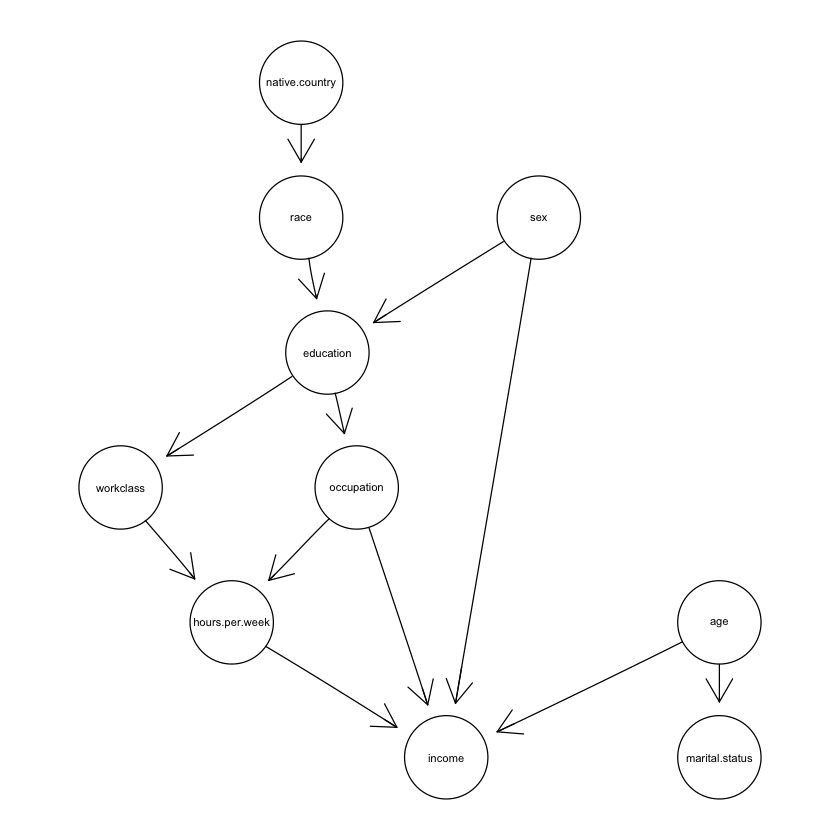

In [4]:
library("gRain")
library("Rgraphviz")
library("dagitty")
library('combinat')

setwd("/Users/apple1/Dropbox/Uni/Nijmegen/WS17_18/BN")
data <- read.table(header=T, sep=",", 'adult_cleaned.csv')


our_network <- dag(~ race:native.country + education:race:sex + workclass:education + hours.per.week:workclass:occupation + occupation:education + marital.status:age + income:age:sex:occupation:hours.per.week)
plot(our_network)
head(data)

data[data=="?"]<-NA
data<-data[complete.cases(data),]

In [2]:
g <- dagitty( "dag{ native.country -> race -> education -> occupation -> hours.per.week -> income; occupation -> income; education -> workclass -> hours.per.week; sex -> education; sex -> income; age -> income; age -> marital.status}" )

In [3]:
independencies <- impliedConditionalIndependencies( g )

In [ ]:
print(independencies)

In [30]:
strata

[[1]]
[1] 1 0 2 3 5 4
Levels: 1 0 2 3 5 4

[[2]]
[1] 0 1 4 5 2 3 6
Levels: 0 1 4 5 2 3 6

In [29]:
dim(expand.grid(strata))

[1] 42  2

In [6]:
num_test <- 0
for(i in 1:length(independencies)){
    indp <- independencies[i]
    xyz <- unlist(indp)
    print(xyz)
    if(length(xyz)>3){

    }
    if(length(xyz)==2){
        print(paste('test: ', xyz[1], ' and ', xyz[2]))
        tst <- chisq.test(data[,xyz[1]], data[,xyz[2]])
        res <- sqrt(max((tst$statistic - tst$parameter)/(( nrow(data) - 1)*tst$parameter),0))
        if(res > 0.05){
            print(res)
        }
        num_test <- num_test + 1
    }
    else{
        print(paste('test ', xyz[1], ' and ', xyz[2], 'given ', xyz[-(1:2)]))
        strata <- list()
        for(i in 1:length(xyz[-(1:2)])){
                strata[i] <- as.data.frame(sort(table(data[,xyz[2+i]]),decreasing=T))
        }
        #strata <- as.data.frame(sort(table(data[,xyz[3]]),decreasing=T))
        visited <- 0
        idx <- 1
        all <- sum(strata['Freq'])
        while(visited<0.8*all){
            print(paste('stratum: ',strata[idx,1]),max.levels=0)
            subdata <- subset(data, data[,xyz[3]] == strata[idx,1])
            x <- subdata[,xyz[1]]
            y <- subdata[,xyz[2]]
            if(length(unique(x)) < 2 || length(unique(y)) < 2){
                break
            }
            tst <- chisq.test(x,y)
            res <- sqrt(max((tst$statistic - tst$parameter)/(( nrow(subdata) - 1)*tst$parameter),0))
            if(res > 0.05){
                print(res)
            }
            
            visited <- visited + strata[idx,2]
            idx <- idx + 1
            num_test <- num_test + 1
        }
    }
}

        1.X         1.Y 
      "age" "education" 
[1] "test:  age  and  education"


Warning message in chisq.test(data[, xyz[1]], data[, xyz[2]]):
“Chi-squared approximation may be incorrect”

             2.X              2.Y 
           "age" "hours.per.week" 
[1] "test:  age  and  hours.per.week"


Warning message in chisq.test(data[, xyz[1]], data[, xyz[2]]):
“Chi-squared approximation may be incorrect”

[1] 0.07403111
             3.X              3.Y 
           "age" "native.country" 
[1] "test:  age  and  native.country"
         4.X          4.Y 
       "age" "occupation" 
[1] "test:  age  and  occupation"


Warning message in chisq.test(data[, xyz[1]], data[, xyz[2]]):
“Chi-squared approximation may be incorrect”

   5.X    5.Y 
 "age" "race" 
[1] "test:  age  and  race"


Warning message in chisq.test(data[, xyz[1]], data[, xyz[2]]):
“Chi-squared approximation may be incorrect”

  6.X   6.Y 
"age" "sex" 
[1] "test:  age  and  sex"
        7.X         7.Y 
      "age" "workclass" 
[1] "test:  age  and  workclass"


Warning message in chisq.test(data[, xyz[1]], data[, xyz[2]]):
“Chi-squared approximation may be incorrect”

             8.X              8.Y             8.Z1             8.Z2 
     "education" "hours.per.week"     "occupation"      "workclass" 
[1] "test  education  and  hours.per.week given  occupation"
[2] "test  education  and  hours.per.week given  workclass" 


Warning message in strata[i] <- as.data.frame(sort(table(data[, xyz[2 + i]]), decreasing = T)):
“number of items to replace is not a multiple of replacement length”Warning message in strata[i] <- as.data.frame(sort(table(data[, xyz[2 + i]]), decreasing = T)):
“number of items to replace is not a multiple of replacement length”

ERROR: Error in sum(strata["Freq"]): invalid 'type' (list) of argument


In [ ]:
num_test

In [ ]:
net1 <- compile( grain( our_network, data, smooth=1 ) )

In [ ]:
pp <- extractCPT( data, our_network, smooth=1)

In [ ]:
querygrain(net1, nodes='income',type = "marginal", evidence = NULL, exclude = TRUE, normalize = TRUE, result = "array", details = 0)

In [ ]:
table(data['income'])

In [ ]:
24720 / (24720+7841)